In [71]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta



In [72]:
#Read csv file
ph = pd.read_csv('priceData/EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv')
ph['Gmt time'] = ph['Gmt time'].apply(lambda x: x.replace('.000', ''))
ph['Gmt time'] = ph['Gmt time'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S'))

In [73]:
#Split price history into groups of 30 min intervals 
#ranges contains consecuative index range of 30 min so if I need data from ph, 
#I can find a group in ranges and use the index range in tht group to get the data from ph
ranges = []
f_returns = [] #as percent change from first price

#Variables:
group_interval = 10
return_candles = 1
start_range = 0
end_range = 0

num_iterations = round((len(ph) / group_interval))
for i in range(num_iterations): 
    end_range = start_range + group_interval-1
    if end_range > len(ph): 
        end_range = len(ph)
        index_range = [start_range, end_range]
    else: 
        index_range = [start_range, end_range]
    ranges.append(index_range)
    start_range += group_interval


for i in ranges: 
    end_index = i[1]
    if end_index < len(ph):
        c_close = ph.iloc[end_index]['Close']
        if end_index + return_candles > len(ph):
            f_close = ph.iloc[len(ph)]['Close']
        else:
            f_close = ph.iloc[end_index + return_candles]['Close']

        price_return = ((f_close - c_close) / c_close) * 100
        f_returns.append(price_return)
    else:
        f_returns.append(np.nan)

ph_grouped = pd.DataFrame({'Range' : ranges, 'Future Candles Return' : f_returns})
ph_grouped.drop(ph_grouped.index[-1], inplace=True)

In [74]:
#Functions
#First function is for finding pivot points in the price movement
def pivotid(df, l, n1, n2): 
    if l-n1 < 0 or l+n2 > len(df): 
        return 0
    
    pividlow = 1
    pividhigh = 1
    for i in range(l-n1, l+n2): 
        if (df.Low[l] > df.Low[i]): 
            pividlow = 0
        if (df.High[l] < df.High[i]): 
            pividhigh = 0
    if pividhigh and pividlow: 
        return 0 
    elif pividlow: 
        return 1
    elif pividhigh: 
        return 2
    else: 
        return 0
    

def pivotpos(df): 
    if df['pivot'] == 1: 
        return df['Low'] - 1e-3
    elif df['pivot'] == 2: 
        return df['High'] + 1e-3
    else: 
        return np.nan
    
def connect_points(df): 
    x_coors = []
    y_coors = []

    x_coors.append(0)
    y_coors.append(df.iloc[0]['High'])

    for i in range (len(df)):
        if df.iloc[i]['pivot'] == 1:
            x_coors.append(i)
            y_coors.append(df.iloc[i]['Low'])
        elif df.iloc[i]['pivot'] == 2:
            x_coors.append(i)
            y_coors.append(df.iloc[i]['High'])
        '''else:
            x_coors.append(df.iloc[i]['Gmt time'])
            y_coors.append'''
    x_coors.append(len(df)-1)
    y_coors.append(df.iloc[len(df)-1]['High'])
    return x_coors, y_coors

def populate(x_coor, y_coor):
    #compute slope between points then create an equation
    #create a new list that for all values between the points used for equations find a y point
    x_coors = []
    y_coors = []
    for i in range(len(x_coor)-1):
        slope = (y_coor[i+1] - y_coor[i]) / (x_coor[i+1] - x_coor[i])
        for j in range(x_coor[i], x_coor[i+1]):
            y = slope * (j-x_coor[i]) + y_coor[i]
            x_coors.append(j)
            y_coors.append(y)
    x_coors.append(x_coor[-1])
    y_coors.append(y_coor[-1])
    return x_coors, y_coors


In [75]:
#Code to create a graph from date over a group's interval then draw lines connecting pivot points
#First test using the first group then write the code as a function that is used over all groups
import plotly.graph_objects as go 
import plotly.express as px
import matplotlib.pyplot as plt
import math

def line_graph(group_num):
    name = 'Group' + str(group_num)
    t_range = ph_grouped.iloc[group_num]['Range']
    s_index = t_range[0]
    e_index  = t_range[1]
    t_ph = ph[s_index:e_index+1].reset_index()
    t_ph['pivot'] = t_ph.apply(lambda x: pivotid(t_ph, x.name, 2,2), axis = 1)

    for rowid in range(len(t_ph)-1): 
        if rowid < len(t_ph):
            if t_ph.iloc[rowid]['pivot'] == t_ph.iloc[rowid+1]['pivot']:
                t_ph.at[rowid,'pivot'] = 0   

    t_ph['pivotpos'] = t_ph.apply(lambda row: pivotpos(row), axis = 1)

    line_x, line_y = connect_points(t_ph)

    p_line_x, p_line_y = populate(line_x, line_y)

    scaled_p_y = [] #Scales graphs with different price ranges to the same 0 to 10 scale
    for i in p_line_y: 
        new_num = ((i - min(p_line_y)) / (max(p_line_y) - min(p_line_y)) * 9 + 1)
        scaled_p_y.append(new_num)


    return scaled_p_y


In [76]:
#This is for creating and saving graph of the line patterns in the stock market
'''fig1 = go.Figure(data = [go.Candlestick(x=t_ph['Gmt time'], 
                                        open=t_ph['Open'],
                                        high=t_ph['High'], 
                                        low=t_ph['Low'], 
                                        close=t_ph['Close'])])
fig1.update_xaxes(rangeslider_visible=False)

fig1.add_scatter(x=t_ph['Gmt time'], 
                y=t_ph['pivotpos'], 
                mode='markers', 
                marker= dict(size=5, color='MediumPurple'), 
                name = 'pivot')'''



'''fig1.add_scatter(x=line_x,
                y=line_y, 
                line=dict(color='blue'))'''

'''fig2 = px.line(x=line_x, y=line_y)
#fig2.update_layout(yaxis={'visible' : False, 'showticklabels' :False}, xaxis={'visible' : False})

fig3 = px.line(x=p_line_x, y=p_line_y)
#fig3.update_layout(yaxis={'visible' : False, 'showticklabels' :False}, xaxis={'visible' : False})

fig4 = px.line(x=p_line_x, y=scaled_p_y)

fig2.show()
fig3.show()
fig4.show()'''

'''fig1.write_image('Images/' + name + '.png')
fig2.write_image('LineGraph/' + name + '.png')'''

"fig1.write_image('Images/' + name + '.png')\nfig2.write_image('LineGraph/' + name + '.png')"

In [77]:
cluster_columns = []
cluster_index = []

for i in range(group_interval): 
    cluster_columns.append(i)

for j in range(len(ph_grouped)):
    cluster_index.append(j)

cluster_data = pd.DataFrame(columns = cluster_columns, index = cluster_index)
for i in range(len(ph_grouped)):
    y_list = line_graph(i)
    cluster_data.loc[i] = y_list
    


C:\Users\kingb\AppData\Local\Temp\ipykernel_10328\721802361.py:29: RuntimeWarning: invalid value encountered in scalar divide
  new_num = ((i - min(p_line_y)) / (max(p_line_y) - min(p_line_y)) * 9 + 1)


In [78]:
cluster_data = cluster_data.dropna()

In [79]:
for i in range(len(cluster_data.columns)): 
    cluster_data[i] = cluster_data[i].astype(float)
cluster_data

#This following data table has each 30-min interval group as a row
#The columns represent each min from 0-29 within the 30 min interval
#All cell values if ploted with the columns on the x would recreate the line pattern derived from the intervals candlestick graph
#All cell values have taken the candle stick graph and scaled each value to 1-10 this preserves the pattern found from the candle stick while normalizing the y axis for each group

,0,1,2,3,4,5,6,7,8,9
0,10.000000,7.807692,5.615385,3.423077,1.230769,1.115385,1.000000,5.153846,3.307692,1.461538
1,10.000000,7.750000,5.500000,3.250000,1.000000,2.695652,4.391304,5.478261,6.565217,7.652174
2,9.437500,6.625000,3.812500,1.000000,3.109375,5.218750,7.328125,9.437500,9.718750,10.000000
3,10.000000,7.750000,5.500000,3.250000,1.000000,2.326923,3.653846,4.980769,5.932692,6.884615
4,6.538462,8.269231,10.000000,7.000000,4.000000,1.000000,3.596154,6.192308,5.326923,4.461538
...,...,...,...,...,...,...,...,...,...,...
22503,3.080189,3.589623,4.099057,4.608491,1.000000,2.800000,4.600000,6.400000,8.200000,10.000000
22504,8.692737,4.846369,1.000000,3.363128,5.726257,1.804469,7.234637,8.156425,9.078212,10.000000
22505,1.000000,1.859926,2.719852,3.579777,4.439703,5.299629,6.159555,7.019481,8.509740,10.000000
22506,10.000000,8.714286,7.428571,6.142857,4.857143,3.571429,2.285714,1.000000,2.613924,4.227848


Following COde runs the k-mean clustering on the data

In [80]:
#Following Code is for k-mean Clustering
cluster_data.describe()

,0,1,2,3,4,5,6,7,8,9
count,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000,22507.000000
mean,6.376953,5.938644,5.500335,5.271442,5.186429,5.175846,5.186152,5.323685,5.647504,6.473500
std,3.419623,2.437589,2.739235,2.780595,2.812629,2.876706,2.975067,3.043916,3.143222,2.978841
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.368421,3.684847,3.400000,3.166494,2.800000,2.690909,2.500000,2.568182,2.759740,4.144753
50%,7.081081,6.228571,5.500000,5.150000,5.121739,5.111364,5.188462,5.423729,5.686528,6.812500
75%,10.000000,8.112903,7.600000,7.573939,7.384308,7.532258,7.750000,8.081139,8.676224,9.432006
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [81]:
#Function for initializing random centroids
def random_centroid(data, k):    
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [82]:
centroids = random_centroid(cluster_data, 5)


#Columns here represent the 5 centroids

C:\Users\kingb\AppData\Local\Temp\ipykernel_10328\1355171620.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  centroid = data.apply(lambda x: float(x.sample()))


In [83]:
#function to label data points to a cluster depending on it closeness to a centroid
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [84]:
labels = get_labels(cluster_data, centroids)
labels.value_counts()

0    7119
2    5013
3    4331
4    3051
1    2993
Name: count, dtype: int64

In [85]:
#updating centroids based on who is in the cluster
def new_centroids(data, labels, k): 
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

In [86]:
#Creating the loop for clustering & visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Come back and fix this part

In [87]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_3d = pca.fit_transform(data)
    centroids_3d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    '''fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], c=labels)
    ax.scatter(centroids_3d[:,0], centroids_3d[:,1], centroids_3d[:,2])'''
    plt.scatter(x=data_3d[:,0], y=data_3d[:,1], c=labels)
    plt.scatter(x=centroids_3d[:,0], y=centroids_3d[:,1])
    plt.show()

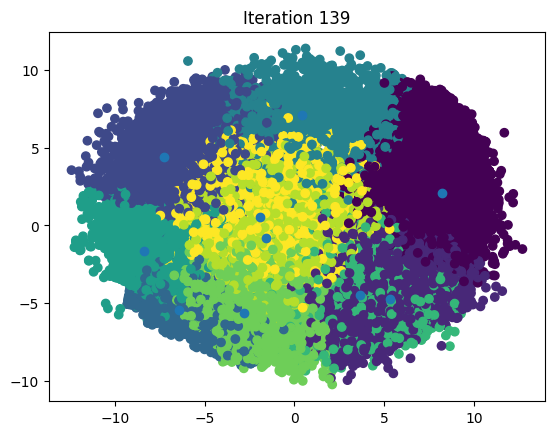

In [88]:
#Body of the function that run k-mean clustering of stock pattern data
max_iterations = 500
k = 10

centroids = random_centroid(cluster_data, k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids

    labels = get_labels(cluster_data, centroids)
    centroids = new_centroids(cluster_data, labels, k)
    plot_clusters(cluster_data, labels, centroids, iteration)
    iteration += 1


In [89]:
centroids

,0,1,2,3,4,5,6,7,8,9
0,1.524939,5.859442,8.184542,9.981122,2.430834,9.380407,2.518224,9.193371,8.676064,4.265508
1,2.645201,4.695608,8.454577,7.079706,4.235681,8.566304,2.795368,7.739788,6.230559,6.079285
2,2.942706,2.918972,8.493094,3.894251,5.209896,7.535614,2.628050,5.955784,3.223004,7.118081
3,4.468185,2.024866,8.454560,2.417117,7.203293,5.862043,2.705261,3.769591,2.466519,8.128706
4,6.256935,2.186009,7.719099,1.816247,8.407725,3.888653,2.605562,2.280359,4.084727,5.970895
5,7.355748,3.985781,6.049930,1.748757,8.453118,2.461538,2.385379,1.910955,6.719310,2.893436
6,7.955040,6.660277,3.804925,1.781006,6.651241,1.938189,2.630349,2.570469,6.347346,2.077237
7,8.255232,8.312048,2.412992,1.976882,4.050099,1.795755,3.937070,4.681846,3.932800,3.420602
8,8.260083,8.604428,2.004985,2.344607,2.760981,2.056355,6.725559,6.586668,2.998659,5.966292
9,8.248568,8.411046,2.883806,3.066476,3.525036,3.293956,9.577340,7.142296,4.167079,7.548795


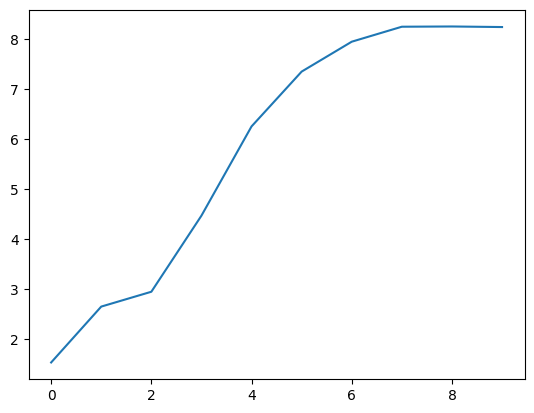

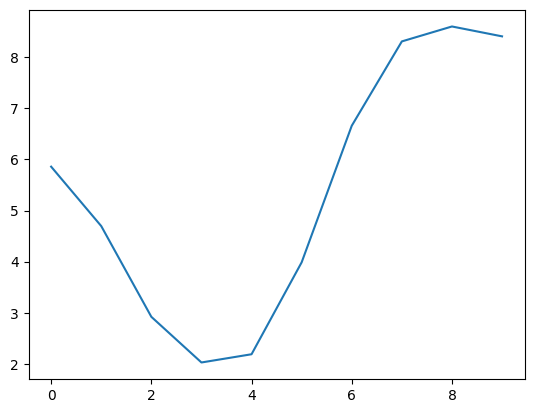

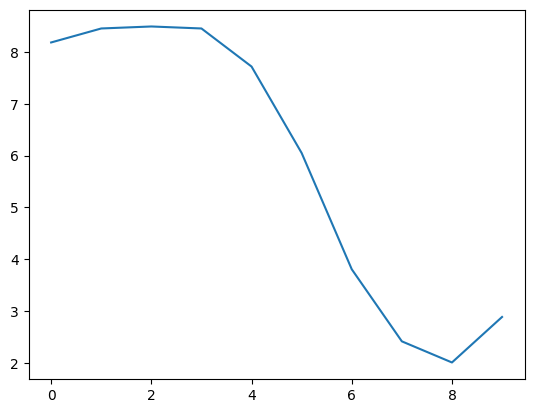

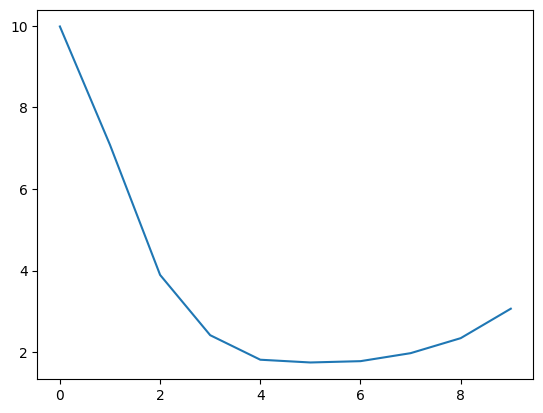

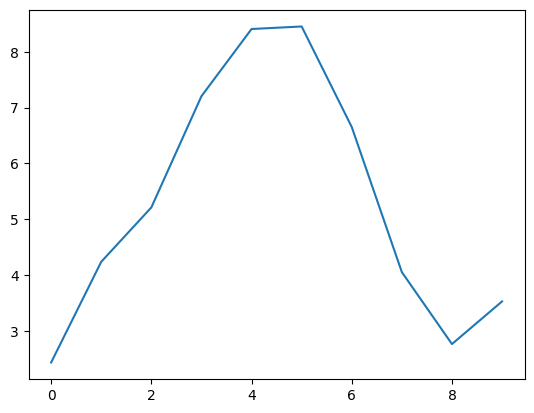

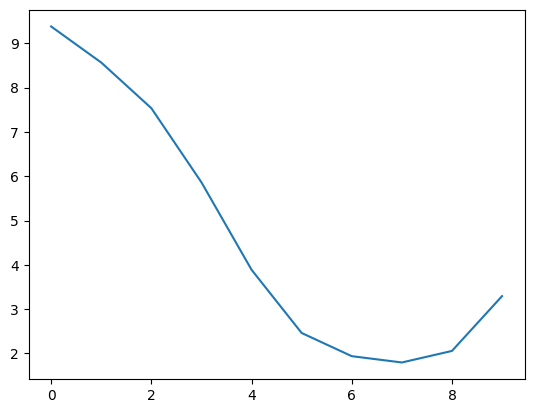

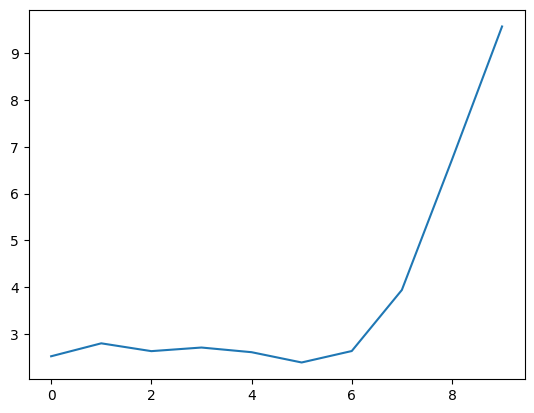

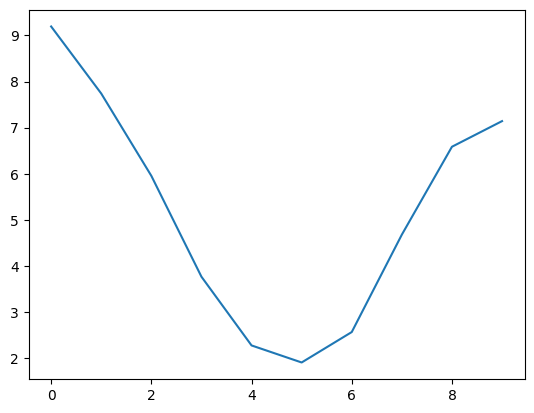

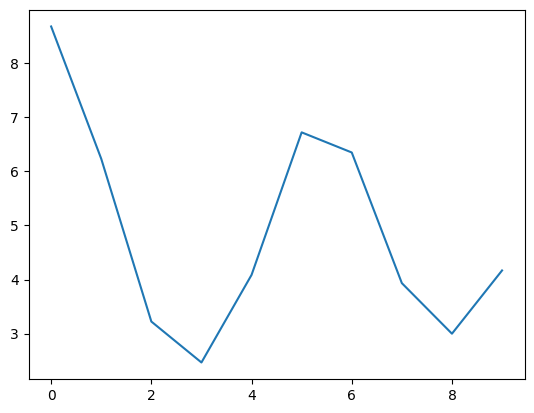

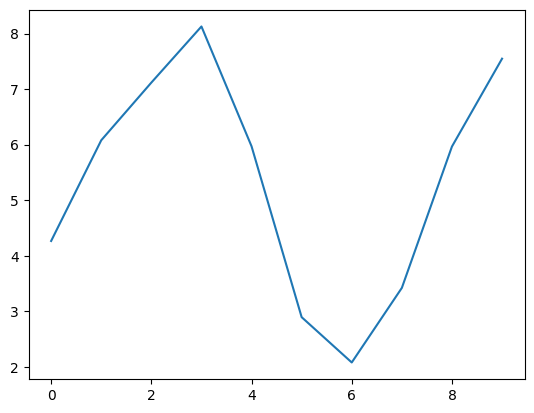

In [90]:
for i in range(k):
    plt.plot(centroids.index, centroids[i])
    plt.show()

In [92]:
for cluster_num in range(k):
    cluster = ph_grouped[labels == cluster_num]
    p_return = 0
    n_return = 0

    for i in range(len(cluster)):
        if cluster.iloc[i]['Future Candles Return'] > 0:
            p_return+=1
        elif cluster.iloc[i]['Future Candles Return'] < 0:
            n_return +=1

    print('Cluster Number: ' + str(cluster_num))
    print(p_return, n_return)

    percent_gain = p_return / (len(cluster)) *100
    percent_loss = n_return / (len(cluster)) *100

    print('Precent Gaining: ' + str(percent_gain) + '%')
    print('Percent Losing: ' + str(percent_loss) +'%')
    print()

#shows first five 30min interval graphs in specified cluster number
'''for i in range(0,5): 
    t_range = cluster.iloc[i]['Range']
    s_index = t_range[0]
    e_index  = t_range[1]
    t_ph = ph[s_index:e_index+1].reset_index()
    figure = go.Figure(data=[go.Candlestick(x=t_ph['Gmt time'], 
                                        open=t_ph['Open'],
                                        high=t_ph['High'], 
                                        low=t_ph['Low'], 
                                        close=t_ph['Close'])])
    figure.show()'''

C:\Users\kingb\AppData\Local\Temp\ipykernel_10328\119271970.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster = ph_grouped[labels == cluster_num]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [46]:
#Creating a strategy based of the stock pattern clustering 
#returning -1 indecates a short signal, returning 1 indicates a long signal.
ph_grouped_copy = ph_grouped
ph_grouped_copy['cluster'] = labels

def trade_potential(row):
    if ph_grouped_copy.iloc[row]['cluster'] == 11:
        return -1
    elif ph_grouped_copy.iloc[row]['cluster'] == 9:
        return 1
    else: 
        return 0

ph_grouped_copy['signal'] = ph_grouped_copy.apply(lambda x: trade_potential(x.name), axis = 1) 


In [47]:
ph_grouped_copy.head()

,Range,Future Candles Return,cluster,signal
0,"[0, 24]",-0.000914,9,1
1,"[25, 49]",0.035677,8,0
2,"[50, 74]",0.040239,5,0
3,"[75, 99]",0.026520,5,0
4,"[100, 124]",-0.017391,9,1


In [48]:
total_returns = 0
for rowid in range(len(ph_grouped_copy)):
    total_returns += abs(ph_grouped_copy.iloc[rowid]['Future Candles Return'])

avg = total_returns / len(ph_grouped_copy)
avg


0.03943537768070233

In [49]:
ph_copy = ph
ph_copy['signal'] = ph.apply(lambda x: 0, axis=1)

for rowid in range(len(ph_grouped_copy)): 
    if ph_grouped_copy.iloc[rowid]['signal'] == 1: 
        range_list = ph_grouped_copy.iloc[rowid]['Range']
        ph_row = range_list[1]
        ph_copy.at[ph_row, 'signal'] = 1
    elif ph_grouped_copy.iloc[rowid]['signal'] == -1:
        range_list = ph_grouped_copy.iloc[rowid]['Range']
        ph_row = range_list[1]
        ph_copy.at[ph_row, 'signal'] = -1


In [ ]:
#Trading Algorithm 
phtest = ph_copy

from backtesting import Strategy
from backtesting import Backtest

phtest = ph[:50000].copy()
#phtest = phtest.set_index('Gmt time')

def SIGNAL(): 
    return phtest.signal


class MyStrat(Strategy): 
    initsize = 0.99
    mysize = initsize

    def init(self): 
        super().init()
        self.signal1 = self.I(SIGNAL)
    
    def next(self): 
        super().next()
        
        if self.signal1 == 1 and len(self.trades) < 1: 
            sl1 = self.data.Close[-1] - self.data.Close[-1] * 0.0004
            tp1 = self.data.Close[-1] + self.data.Close[-1] * 0.0004
            self.buy(sl = sl1, tp = tp1, size = self.mysize)
        
        if self.signal1 == -1 and len(self.trades) < 1: 
            sl1 = self.data.Close[-1] + self.data.Close[-1] * 0.0004
            tp1 = self.data.Close[-1] - self.data.Close[-1] * 0.0004
            self.sell(sl = sl1, tp = tp1, size = self.mysize)
bt = Backtest(phtest, MyStrat, cash = 1000, margin = 1/10, commission = 0.00)
stat = bt.run()
stat

C:\Users\kingb\AppData\Local\Temp\ipykernel_53912\2000420913.py:34: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(phtest, MyStrat, cash = 1000, margin = 1/10, commission = 0.00)


Start                                     0.0
End                                   49999.0
Duration                              49999.0
Exposure Time [%]                       6.974
Equity Final [$]                   895.857475
Equity Peak [$]                   1013.163225
Return [%]                         -10.414252
Buy & Hold Return [%]                1.822569
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.941117
Avg. Drawdown [%]                   -2.169399
Max. Drawdown Duration                46522.0
Avg. Drawdown Duration                 6148.5
# Trades                                370.0
Win Rate [%]                        46.486486
Best Trade [%]                       0.064195
Worst Trade [%]                     -0.106965
Avg. Trade [%]                    